In [34]:
import os
import pandas as pd
import datetime
import neurokit2 as nk
import nptdms
import numpy as np
import nptdms


path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"

path_patient = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"



In [26]:
# Load RR intervals from file (header lines 1-20, data starts at line 23)
# The file uses tabs as separators and comma as decimal separator (e.g. "0,000000\t0,244154")
skiprows = 22

# read with explicit tab separator and decimal comma; fallback to whitespace if needed
try:
    df_raw = pd.read_csv(path, skiprows=skiprows, sep='\t', header=0, engine='python', decimal=',')
except Exception:
    df_raw = pd.read_csv(path, skiprows=skiprows, header=0, delim_whitespace=True, engine='python', decimal=',')

# If no header row was present, ensure columns are strings and try again using first row as header
if df_raw.columns.to_series().astype(str).str.contains('[A-Za-z]').any() is False and df_raw.iloc[0].astype(str).str.contains('[A-Za-z]').any():
    df_raw = pd.read_csv(path, skiprows=skiprows, header=0, sep='\t', engine='python', decimal=',')

# Prefer numeric-typed columns; otherwise coerce columns to numeric (handling comma decimals)
num_cols = df_raw.select_dtypes(include=['number']).columns
if len(num_cols) > 0:
    rr = df_raw[num_cols[1]].dropna().reset_index(drop=True)
else:
    # coerce by replacing comma with dot then converting
    coerced = df_raw.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
    numeric_mask = coerced.notna().sum() > 0
    if numeric_mask.any():
        rr = coerced.loc[:, numeric_mask].iloc[:, 0].dropna().reset_index(drop=True)
    else:
        # fallback: first column
        rr = pd.to_numeric(df_raw.iloc[:, 0].astype(str).str.replace(',', '.'), errors='coerce').dropna().reset_index(drop=True)

rr.name = 'RR'
print(f"Loaded {len(rr)} RR intervals")
rr.head()

Loaded 186084 RR intervals


0    0.331858
1    0.382904
2    0.167871
3    0.204339
4    0.220332
Name: RR, dtype: float64

In [27]:
total_time = rr.sum()
print(f"Total time in rr: {total_time} seconds")


Total time in rr: 160685.028189 seconds


In [28]:
import numpy as np
import pandas as pd

# Create a DataFrame with 1's at R-peak indices

# Calculate cumulative sum of RR intervals to get R-peak times in seconds
rpeak_times = rr.cumsum()

# Convert R-peak times to sample indices
rpeak_indices = (rpeak_times * fs).round().astype(int)

# Create a DataFrame with 1's at R-peak indices
wf_increase = np.zeros(int(s_total * fs))  # Total samples based on s_total and fs
wf_increase[rpeak_indices] = 1  # Set 1's at R-peak indices

# Convert to DataFrame
df_rpeaks = pd.DataFrame({'R_Peak': wf_increase})
print(f"Created DataFrame with shape: {df_rpeaks.shape}")
df_rpeaks.head()

Created DataFrame with shape: (82460288, 1)


,R_Peak
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [48]:
# Merge RR intervals shorter than 0.27 s into the smaller adjacent interval.
# Uses existing `rr` Series from the notebook.
threshold = 60/220

vals = rr.tolist()
removed = 0

while True:
    # find first short interval
    short_idx = next((i for i, v in enumerate(vals) if v < threshold), None)
    if short_idx is None:
        break

    v = vals[short_idx]
    # choose neighbor (previous or next) with the smaller value (handle edges)
    if short_idx == 0:
        neighbor = 1
    elif short_idx == len(vals) - 1:
        neighbor = short_idx - 1
    else:
        neighbor = short_idx - 1 if vals[short_idx - 1] <= vals[short_idx + 1] else short_idx + 1

    # add short interval to chosen neighbor and remove it
    vals[neighbor] += v
    vals.pop(short_idx)
    removed += 1

rr_clean = pd.Series(vals, name='RR')
print(f"Removed {removed} short intervals. Before: {len(rr)}, After: {len(rr_clean)}")

Removed 13435 short intervals. Before: 186084, After: 172649


In [30]:
print(len(rr_clean))

172649


In [31]:
rr_clean_total = 0

for i in rr_clean:
    rr_clean_total += i

print(f"Total duration of cleaned RR intervals: {rr_clean_total} seconds")

Total duration of cleaned RR intervals: 160685.02818899963 seconds


In [32]:
fs = 512
s_total = 82460288/fs
print(f"Total duration based on original signal sampling rate: {s_total} seconds")

remaining_time = s_total - total_time
print(f"Remaining time after subtracting total_time from s_total: {remaining_time} seconds")

remove_start = 60
print(f"Samples to remove at start: {remove_start}")
remove_end = 300
print(f"Samples to remove at end: {remove_end}")

s_missing = s_total - (total_time + (remove_start + remove_end))
print(f"Missing time after removing start/end: {s_missing} seconds")

# From timestamp in rr-result file is shown a start time of 11:06:19,181654
# From the ECG file there is a offset of 17 seconds

Total duration based on original signal sampling rate: 161055.25 seconds
Remaining time after subtracting total_time from s_total: 370.2218109999958 seconds
Samples to remove at start: 60
Samples to remove at end: 300
Missing time after removing start/end: 10.221810999995796 seconds


In [35]:

# Read TDMS file
try:
    tdms = nptdms.TdmsFile.read(path_patient)
except Exception as e:
    raise RuntimeError(f"Failed to read TDMS file: {e}")

# List groups
groups = tdms.groups()
print("Groups found:", [g.name for g in groups])

# Collect channel data into a dict of pandas Series
channels = {}
tdms_time_printed = globals().get('tdms_time_printed', False)

for g in groups:
    for ch in g.channels():
        key = f"{g.name}.{ch.name}"
        try:
            arr = ch[:]  # numpy array of channel samples
        except Exception:
            arr = ch.data  # fallback
        channels[key] = pd.Series(arr, name=key)

        # Print "Time" from TDMS header/properties once
        if not tdms_time_printed:
            time_val = None

            # file-level properties
            props = getattr(tdms, "properties", {}) or {}
            if isinstance(props, dict):
                for k, v in props.items():
                    if "time" in str(k).lower():
                        time_val = v
                        break

            # fallback: file_info dict-like
            if time_val is None and hasattr(tdms, "file_info"):
                fi = getattr(tdms, "file_info") or {}
                if isinstance(fi, dict):
                    for k, v in fi.items():
                        if "time" in str(k).lower():
                            time_val = v
                            break

            # channel-level properties
            if time_val is None and hasattr(ch, "properties"):
                ch_props = getattr(ch, "properties") or {}
                if isinstance(ch_props, dict):
                    for k, v in ch_props.items():
                        if "time" in str(k).lower():
                            time_val = v
                            break

            if time_val is not None:
                print("Time from header:", time_val)
            else:
                print("No 'Time' property found in TDMS header/channel properties")

            globals()["tdms_time_printed"] = True
            tdms_time_printed = True

# Build DataFrame (will align by index; if lengths differ, shorter series get NaN)
df_tdms = pd.concat(channels, axis=1)

print(f"Loaded TDMS with shape: {df_tdms.shape}")
df_tdms.head()


Groups found: ['Untitled']
Time from header: 2016-10-12T09:05:02.000000
Loaded TDMS with shape: (82460288, 1)


,Untitled.EKG
0,-70.270817
1,-1.377859
2,37.202197
3,-45.469352
4,-144.675212


In [36]:
# Clean ECG signal (uses existing `df_tdms` and `key` variables)
signal = df_tdms[key]  # 'Untitled.EKG'
ecg_cleaned = nk.ecg_clean(signal, method="neurokit")  # adjust method/sampling_rate if needed

# Save cleaned signal to dataframe and show a quick check
df_tdms["EKG_clean"] = ecg_cleaned
print(f"Cleaned ECG signal: {len(ecg_cleaned)} samples. Added column 'EKG_clean' to df_tdms.")
df_tdms[["Untitled.EKG", "EKG_clean"]].head()

Cleaned ECG signal: 82460288 samples. Added column 'EKG_clean' to df_tdms.


,Untitled.EKG,EKG_clean
0,-70.270817,-549.314036
1,-1.377859,-553.209804
2,37.202197,-557.270345
3,-45.469352,-561.564011
4,-144.675212,-565.635597


In [37]:
import numpy as np

# Try to infer sampling rate from TDMS channel properties (common property names)
srate = None
if 'ch' in globals() and hasattr(ch, "properties"):
    for key in ("wf_sample_rate", "sample_rate", "sampling_rate", "Rate", "rate"):
        if key in ch.properties and ch.properties[key] not in (None, ""):
            srate = ch.properties[key]
            break

# Normalize srate type if present
try:
    if isinstance(srate, (bytes, bytearray)):
        srate = float(srate.decode())
    elif srate is not None:
        srate = float(srate)
except Exception:
    srate = None

# Fallback sampling rate (adjust if you know the true rate)
if srate is None:
    srate = 512.0  # change this to the correct sampling rate if known
print(f"Using sampling rate = {srate} Hz")

# Detect R-peaks with NeuroKit2
signals, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=int(srate))

# Extract R-peak indices (NeuroKit returns a dict under key 'ECG_R_Peaks')
if isinstance(info, dict) and "ECG_R_Peaks" in info:
    rpeak_indices = np.asarray(info["ECG_R_Peaks"])
else:
    # fallback: try to extract first array found in `info`
    if isinstance(info, dict) and len(info) > 0:
        first_val = next(iter(info.values()))
        rpeak_indices = np.asarray(first_val)
    else:
        # if something unexpected, make empty array
        rpeak_indices = np.array([], dtype=int)

print(f"Detected {len(rpeak_indices)} R-peaks")

# Compute times of R-peaks (seconds)
times = np.arange(len(ecg_cleaned)) / float(srate)
rpeak_times = times[rpeak_indices]
rr_intervals = np.diff(rpeak_times, prepend=0)

# Optionally mark R-peaks in df_tdms if lengths match
if 'df_tdms' in globals() and len(df_tdms) == len(ecg_cleaned):
    df_tdms["R_Peak"] = False
    df_tdms.loc[rpeak_indices, "R_Peak"] = True
    print("Added boolean 'R_Peak' column to df_tdms.")
else:
    if 'df_tdms' in globals():
        print("df_tdms length does not match signal length; not adding 'R_Peak' column.")

# Expose results in variables for further use
rpeaks_indices = rpeak_indices
rpeaks_times = rpeak_times

# Quick preview
print("First 10 R-peak indices:", rpeaks_indices[:10])
print("First 10 R-peak times (s):", rpeaks_times[:10])

Using sampling rate = 512.0 Hz
Detected 167333 R-peaks
Added boolean 'R_Peak' column to df_tdms.
First 10 R-peak indices: [1218 2387 2785 3037 4280 4991 6417 6817 8551 9145]
First 10 R-peak times (s): [ 2.37890625  4.66210938  5.43945312  5.93164062  8.359375    9.74804688
 12.53320312 13.31445312 16.70117188 17.86132812]


In [38]:
print(f"Amount of R-peaks detected: {len(rpeak_indices)}")

Amount of R-peaks detected: 167333


In [41]:
# Count the number of correct R-peak indices within a window of 10 indices
correct_rpeaks = 0
window = 10

for idx in rpeak_indices:
    if df_rpeaks.iloc[max(0, idx - window):min(len(df_rpeaks), idx + window + 1)]["R_Peak"].sum() > 0:
        correct_rpeaks += 1

print(f"Number of correct R-peak indices within a window: {correct_rpeaks}")
print(f"Total R-peak indices detected: {len(rpeak_indices)}")
print(f"Accuracy: {correct_rpeaks / len(rpeak_indices) * 100:.2f}%")

Number of correct R-peak indices within a window: 7923
Total R-peak indices detected: 167333
Accuracy: 4.73%


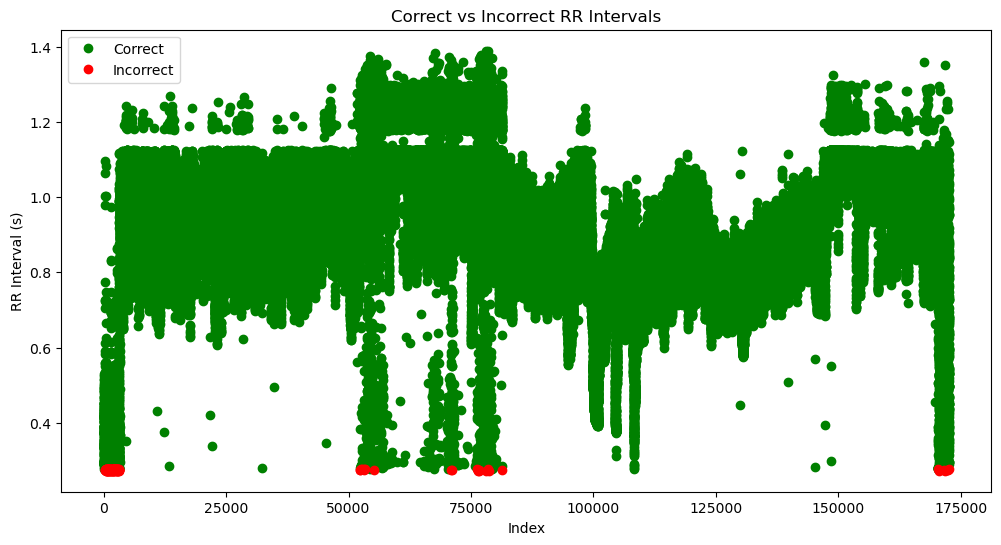

In [47]:
import matplotlib.pyplot as plt

# Define the threshold for comparison (30ms in seconds)
threshold_seconds = 0.03

# Initialize lists to store indices and values
incorrect_indices = []
correct_indices = []

# Iterate through the cleaned RR intervals
for idx, rr_val in enumerate(rr_clean):
    # Check if there is any detected RR interval within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        correct_indices.append(idx)
    else:
        incorrect_indices.append(idx)

# Save the indices
incorrect_indices = np.array(incorrect_indices)
correct_indices = np.array(correct_indices)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(correct_indices, rr_clean.iloc[correct_indices], 'go', label='Correct')
plt.plot(incorrect_indices, rr_clean.iloc[incorrect_indices], 'ro', label='Incorrect')
plt.xlabel('Index')
plt.ylabel('RR Interval (s)')
plt.title('Correct vs Incorrect RR Intervals')
plt.legend()
plt.show()

Precise matches: 359
Matches within a window of 30ms: 172649
Total RR intervals in rr_clean: 172649
Total RR intervals in rr_intervals: 167333
Number of correct matches: 172649
Number of incorrect matches: 0
Accuracy: 100.00%


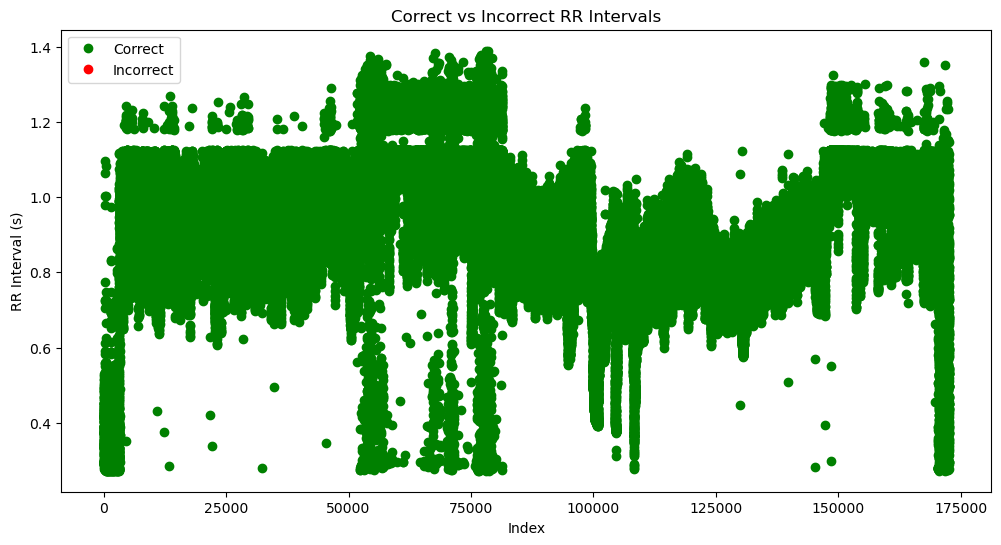

In [53]:
# Define the threshold for comparison (40ms in seconds)
threshold_seconds = 0.04

# Initialize counters for precise matches and matches within the threshold
precise_matches = 0
window_matches = 0

# Iterate through the cleaned RR intervals
for rr_val in rr_clean:
    # Check for precise match
    if rr_val in rr_intervals:
        precise_matches += 1

    # Check for match within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        window_matches += 1

# Print the results
print(f"Precise matches: {precise_matches}")
print(f"Matches within a window of 30ms: {window_matches}")
print(f"Total RR intervals in rr_clean: {len(rr_clean)}")
print(f"Total RR intervals in rr_intervals: {len(rr_intervals)}")


# Initialize counters for correct and incorrect indices
correct_indices = []
incorrect_indices = []

# Iterate through the cleaned RR intervals
for idx, rr_val in enumerate(rr_clean):
    # Check if there is any detected RR interval within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        correct_indices.append(idx)
    else:
        incorrect_indices.append(idx)

# Save the indices
correct_indices = np.array(correct_indices)
incorrect_indices = np.array(incorrect_indices)

# Calculate the number of correct and incorrect matches
num_correct = len(correct_indices)
num_incorrect = len(incorrect_indices)

# Print the results
print(f"Number of correct matches: {num_correct}")
print(f"Number of incorrect matches: {num_incorrect}")
print(f"Accuracy: {num_correct / len(rr_clean) * 100:.2f}%")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(correct_indices, rr_clean.iloc[correct_indices], 'go', label='Correct')
plt.plot(incorrect_indices, rr_clean.iloc[incorrect_indices], 'ro', label='Incorrect')
plt.xlabel('Index')
plt.ylabel('RR Interval (s)')
plt.title('Correct vs Incorrect RR Intervals')
plt.legend()
plt.show()

In [46]:
0.03/ (1/512)

15.36